In [136]:
import librosa
import librosa.display
import os

import warnings
warnings.filterwarnings("ignore")

path_to_db_voice = "D:\\Utilisateurs\\ENAC\\projet_AIRBUS\\db\\voice\\"
path_to_db_plane = "D:\\Utilisateurs\\ENAC\\projet_AIRBUS\\db\\plane\\"
path_to_db_both = "D:\\Utilisateurs\\ENAC\\projet_AIRBUS\\db\\both\\"

l_voice_records = os.listdir(path_to_db_voice)
l_airplane_records = os.listdir(path_to_db_plane)
l_both_records = os.listdir(path_to_db_both)

In [137]:
import random as rd

def separe_train_test(db_folder_path,n_records,test_size):
    l_records = os.listdir(db_folder_path)
    sub_l_records = rd.sample(l_records,n_records)
    size = len(sub_l_records)
    sep = round(test_size*size)
    sample = rd.sample(sub_l_records,size)
    test = sample[:sep]
    train = sample[sep:]
    return train,test

In [138]:
import numpy as np
from time import time 
import matplotlib.pyplot as plt
def gen_X_train_test(db_folder_path,n_records,test_size):
    sp_rec_train = []
    sp_rec_test = []
    records_train,records_test = separe_train_test(db_folder_path,n_records,test_size)
    i = 0
    for record in records_train:
        print('Building train {}/{}'.format(i,len(records_train)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=False) 
        spectrum = spectrum.astype(float)
        sp_rec_train.append(np.abs(np.transpose(spectrum)))
        i+=1
        # plt.hist(np.unique(spectrum),bins=200)
        # plt.yscale('log')
        # fig = librosa.display.specshow(spectrum, sr=sample_rate, x_axis='time', y_axis='log')
        # plt.colorbar(format='%+2.0f dB')
        # plt.title('Spectrogram')
        # plt.plot()
        # plt.show()
    i=0
    for record in records_test: 
        print('Building  test {}/{}'.format(i,len(records_test)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=False) 
        spectrum = spectrum.astype(float)
        sp_rec_test.append(np.abs(np.transpose(spectrum)))
        i+=1

    X_train = np.concatenate(sp_rec_train)
    X_test = np.concatenate(sp_rec_test)

    return X_train,X_test

In [148]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import threading

n_records = 50

X_voice_train,X_voice_test = gen_X_train_test(path_to_db_voice,n_records,0.9)
print('Voice done',end='\r')
X_plane_train,X_plane_test = gen_X_train_test(path_to_db_plane,n_records,0.9)
print('Plane done',end='\r')
X_both_train,X_both_test = gen_X_train_test(path_to_db_both,n_records,0.9)
print('Both done',end='\r')

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

threshold = 10

# y_voice_train = ['Voice' if max(elt)>threshold else 'Silence' for elt in X_voice_train]
# y_plane_train = ['Plane' if max(elt)>threshold else 'Silence' for elt in X_plane_train]
# y_both_train = ['Voice' if max(elt)>threshold else 'Silence' for elt in X_both_train]

# y_voice_test = ['Voice' if max(elt)>threshold else 'Silence' for elt in X_voice_test]
# y_plane_test = ['Plane' if max(elt)>threshold else 'Silence' for elt in X_plane_test]
# y_both_test = ['Voice' if max(elt)>threshold else 'Silence' for elt in X_both_test]

y_voice_train = ['Voice' for elt in X_voice_train]
y_plane_train = ['Plane' for elt in X_plane_train]
y_both_train = ['Voice' for elt in X_both_train]

y_voice_test = ['Voice' for elt in X_voice_test]
y_plane_test = ['Plane' for elt in X_plane_test]
y_both_test = ['Voice' for elt in X_both_test]

X_train = np.concatenate([X_voice_train,X_plane_train,X_both_train])
X_test = np.concatenate([X_plane_test,X_both_test])

y_train = y_voice_train + y_plane_train + y_both_train
y_test =y_plane_test + y_both_test


PARTIE MODELE

In [141]:
# pca = PCA(0.99).fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [142]:
from sklearn.metrics import accuracy_score

pred = rf.predict(X_test)
accuracy_score(pred,y_test)

0.7803234501347709

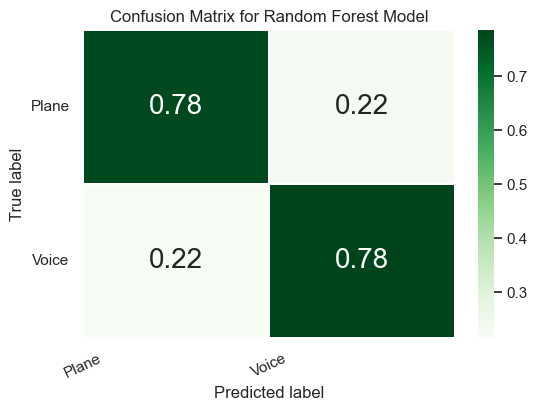

In [145]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

pred = rf.predict(X_test)
matrix = confusion_matrix(pred,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = rf.classes_
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

TEST DE LA RF SAUVEGARDEE

In [146]:
import joblib 

rf = joblib.load("random_forest.joblib")
# joblib.dump(rf, "random_forest.joblib")


In [150]:
pred = rf.predict(X_test)

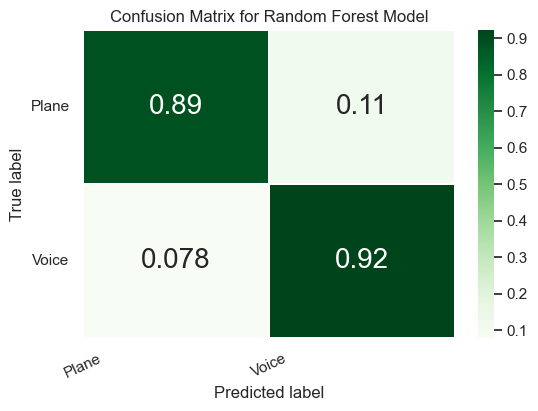

In [151]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

pred = rf.predict(X_test)
matrix = confusion_matrix(pred,y_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = rf.classes_
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()